<h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 3 of 4</p>

1. [Problem Statement](#problem)
2. [Question 3](#question)
3. [Data Cleaning and Standardization](#wrangling)
4. [Analyzing and Visualizing](#analysis)
5. [Concluding Remarks](#conclusion)

<a id="problem"></a>
# Problem Statement
---

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

<a id="question"></a>
# Question 3
---

Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

## Approach
Determine whether or not there are any correlations between the building characteristics of buildings that experienced HEAT/HOT WATER complaints (from Question 1) relative to the building characteristics of all buildings in the PLUTO house database.

## Load Data
Separately from this notebook:

The [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

The [New York PLUTO](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/xuk2-nczf) data was downloaded.  The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, only the BX_18v1.csv file was loaded into a Pandas DataFrame then saved to a pickle file

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import seaborn as sns

files_path = 'C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\' #local
#files_path = './' #IBM Cloud / Watson Studio

In [2]:
b311 = pd.read_pickle(files_path + 'ny311full.pkl')

#bPlu = pd.read_csv(files_path + 'BX_18v1.csv', usecols=['Address','BldgArea','BldgDepth','BuiltFAR','CommFAR','FacilFAR','Lot','LotArea','LotDepth','NumBldgs','NumFloors','OfficeArea','ResArea','ResidFAR','RetailArea','YearBuilt','YearAlter1','ZipCode', 'YCoord', 'XCoord'])
#bPlu.to_pickle(files_path + 'BX_18v1.pkl')
bPlu = pd.read_pickle(files_path + 'BX_18v1.pkl')

print("NY 311 shape %s" % (b311.shape,))
print("BRONX PLUTO shape %s" % (bPlu.shape,))

NY 311 shape (5862383, 15)
BRONX PLUTO shape (89854, 20)


<a id="wrangling"></a>
# Data Cleaning and Standardization
---

Observations with missing or malformed data elements will need to be corrected or removed.  The 311 and the PLUTO data sets will need to be "joined" together by the common "address" element, which means the addresses will need to be standardized to a consistent layout to allow the addresses to be compared consistently.

## NY 311

### General

In [3]:
#Remove columns deemed unnecessary for this question.
b311.drop(['created_date','street_name','address_type','resolution_description','closed_date','location_type','status','unique_key','latitude','longitude'], axis=1, inplace=True)
#Only use the combined "heating and hot water" complaints determined from Question 1.
b311['complaint_type'] = b311['complaint_type'].str.upper()
b311.drop(b311[b311["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==True].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Adjust all relevant strings to uppercase so different casing won't appear as separate values.
b311['incident_address'] = b311['incident_address'].str.upper()
b311['city'] = b311['city'].str.upper()
b311['borough'] = b311['borough'].str.upper()

In [4]:
#Print some initial information for comparison during later steps.
print("shape %s" % str(b311.shape))
print("--nulls below--")
print(b311.isnull().sum())
print("--types below--")
print(b311.dtypes)
b311.head()

shape (3821922, 5)
--nulls below--
complaint_type          0
incident_zip        61641
incident_address    52830
city                61367
borough                 0
dtype: int64
--types below--
complaint_type       object
incident_zip        float64
incident_address     object
city                 object
borough              object
dtype: object


,complaint_type,incident_zip,incident_address,city,borough
0,ELECTRIC,11435.0,141-40 PERSHING CRESCENT,JAMAICA,QUEENS
1,FLOORING/STAIRS,11223.0,1702 WEST 1 STREET,BROOKLYN,BROOKLYN
2,APPLIANCE,10456.0,881 CAULDWELL AVENUE,BRONX,BRONX
3,PAINT/PLASTER,11205.0,196 CLINTON AVENUE,BROOKLYN,BROOKLYN
4,PAINT/PLASTER,10034.0,133 SEAMAN AVENUE,NEW YORK,MANHATTAN


### Standardize Borough
Leveraging findings found while standardizing during Question 2.

In [5]:
b311['borough'].value_counts()

BROOKLYN         1149629
BRONX             996286
MANHATTAN         621609
UNSPECIFIED       590309
QUEENS            395876
STATEN ISLAND      68213
Name: borough, dtype: int64

In [6]:
#Correct rows where borough was entered in the city column with "UNSPECIFIED" in the borough column.
five_boroughs = ["BROOKLYN","BRONX","MANHATTAN","QUEENS","STATEN ISLAND"]
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(five_boroughs)].index
b311.loc[which_rows_to_adjust,'borough']=b311.loc[which_rows_to_adjust,'city']
b311.loc[which_rows_to_adjust,'city']=np.nan
#Drop a few rows of ambiguous data.
b311.drop(b311[(b311["borough"]=='MANHATTAN')&(b311["city"]=='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Fill in UNSPECIFIED borough when city was entered as NEW YORK.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'borough']="MANHATTAN"
b311.loc[which_rows_to_adjust,'city']=np.nan
#Although the city for most of the "NEW YORK" ones are the only ones that technically got the "city" column valued correctly,
#since every other row uses city as "neighborhood":  Standardize these.
which_rows_to_adjust = b311[(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'city']=np.nan
#Any still unspecified boroughs with a value in "city" are in the Queens borough.  The "city" is actually a "neighborhood".
queens_neighborhoods = b311[(b311['borough']=='UNSPECIFIED')&(b311['city'].isnull()==False)]['city'].unique()
#Standardize borough for Queens neighborhoods.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(queens_neighborhoods)].index
b311.loc[which_rows_to_adjust,'borough']="QUEENS"
#Null the borough if it still shows up as unspecified borough as there is no other information from which to derive it.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isnull()].index
b311.loc[which_rows_to_adjust,'borough']=np.nan

In [7]:
b311['borough'].value_counts()

BROOKLYN         1351604
BRONX            1158369
MANHATTAN         717580
QUEENS            462111
STATEN ISLAND      79117
Name: borough, dtype: int64

### Filter NY 311 data by borough to only include BRONX
The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, I am only considering the BRONX data.

In [8]:
b311.drop(b311[(b311["borough"]!='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
b311['borough'].value_counts()

BRONX    1158369
Name: borough, dtype: int64

### Remove unnecessary columns
These were only necessary to standardize and then filter by borough.

In [9]:
#Remove columns no longer necessary
b311.drop(['borough','city'], axis=1, inplace=True)
print(b311.shape)
print(b311.isnull().sum())
b311.head()

(1158369, 3)
complaint_type         0
incident_zip        2126
incident_address       0
dtype: int64


,complaint_type,incident_zip,incident_address
0,APPLIANCE,10456.0,881 CAULDWELL AVENUE
1,PLUMBING,10452.0,133 CLARKE PLACE EAST
2,PAINT/PLASTER,10453.0,2076 CRESTON AVENUE
3,SAFETY,10471.0,6035 BROADWAY
4,APPLIANCE,10460.0,960 EAST 173 STREET


In [10]:
# Drop the one observation with the missing address as there will be no way to tie it to any PLUTO data.
b311.dropna(subset=['incident_address'], axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
print(b311.isnull().sum())
b311['incident_address'].value_counts().head()

complaint_type         0
incident_zip        2126
incident_address       0
dtype: int64


1025 BOYNTON AVENUE        4081
3230 CRUGER AVENUE         2876
3555 BRUCKNER BOULEVARD    2629
3451 GILES PLACE           2552
750 GRAND CONCOURSE        2259
Name: incident_address, dtype: int64

## BRONX PLUTO

In [11]:
print("shape %s" % str(bPlu.shape))
print("---isnull follows---")
print(bPlu.isnull().sum())
bPlu.head()

shape (89854, 20)
---isnull follows---
Lot              0
ZipCode        329
Address         69
LotArea          0
BldgArea         0
ResArea          0
OfficeArea       0
RetailArea       0
NumBldgs         0
NumFloors        0
LotDepth         0
BldgDepth        0
YearBuilt        0
YearAlter1       0
BuiltFAR         0
ResidFAR         0
CommFAR          0
FacilFAR         0
XCoord        3259
YCoord        3259
dtype: int64


,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


### General

In [12]:
bPlu.dtypes

Lot             int64
ZipCode       float64
Address        object
LotArea         int64
BldgArea        int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
NumBldgs        int64
NumFloors     float64
LotDepth      float64
BldgDepth     float64
YearBuilt       int64
YearAlter1      int64
BuiltFAR      float64
ResidFAR      float64
CommFAR       float64
FacilFAR      float64
XCoord        float64
YCoord        float64
dtype: object

In [13]:
#Adjust relevant strings to uppercase so different casing won't appear as separate values.
bPlu['Address'] = bPlu['Address'].str.upper()

In [14]:
# Drop the observations with missing address as there will be no way to tie it to any 311 data.
bPlu.dropna(subset=['Address'], axis=0, inplace=True)
bPlu.reset_index(drop=True, inplace=True)

## Standardization of Addresses
Leveraging standardization methods developed during question 2.

In [15]:
print("BRONX 311 unique addresses: %s" % b311['incident_address'].unique().size)
print("BRONX PLUTO unique addresses: %s" % bPlu['Address'].unique().size)

BRONX 311 unique addresses: 23123
BRONX PLUTO unique addresses: 87017


<p style="color:Red;">Determine how much overlap.  Ideally all 29K BRONX 311 addresses will be represented in the PLUTO set.</p>

In [16]:
def WhichAddressesNotInPluto(howManyTopToShow):
    complaints = set(b311['incident_address'].unique())
    pluto = set(bPlu['Address'].unique())
    #Determine which 311 addresses were not found in PLUTO to gain insight as to why.
    differences = complaints.difference(pluto)
    print("Records not in PLUTO: %s.  Percent: %s" % (len(differences), "{:.2%}".format(len(differences) / len(complaints))))
    print("---Top %i---" % howManyTopToShow)
    print(b311[b311['incident_address'].isin(differences)]['incident_address'].value_counts().head(howManyTopToShow))

In [17]:
WhichAddressesNotInPluto(3)

Records not in PLUTO: 5187.  Percent: 22.43%
---Top 3---
20 RICHMAN PLAZA    1756
1259 CLAY AVENUE    1641
30 RICHMAN PLAZA    1282
Name: incident_address, dtype: int64


<p style="color:Red;">Over 20 percent of addresses in the BRONX 311 data cannot be merged to the BRONX PLUTO data.</p>

### Borrow some python functions developed during question 2
With minor improvements to better work with full addresses instead of just street names.

In [18]:
# Some street values have multiple spaces in a row.
import re
def standardize_spaces(raw):
    result = raw.strip() #Remove leading and trailing spaces.
    result = re.sub(' +', ' ', result) #Squeeze multiple adjacent spaces into just one space.
    return result

In [19]:
# Some streets have problematic characters.  For example:  ST. ANN'S AVENUE also exists without period or apostophe.
problem_characters = ['.', '\'']
def replace_problem_characters(raw):
    result = raw
    for (character) in problem_characters:
        result = result.replace(character,'')
    return result

In [20]:
#Some words are sometimes entered in a non-standard way or with typos need to be standardized.
word_replacements = [("AVE","AVENUE"),("ST","STREET"),("RD","ROAD"),("FT","FORT"),("BX","BRONX"),("MT","MOUNT"),
                     ("NICHLAS","NICHOLAS"),("NICHALOS","NICHOLAS"),("EXPRE","EXPRESSWAY"),("HARACE","HORACE"),
                     ("NO","NORTH"),("AV","AVENUE"),("CRK","CREEK"),("FR","FATHER"),("JR","JUNIOR"),("GR","GRAND"),
                     ("CT","COURT"),
                     ("SR",""), # Service Road.  These are always near a similarly named street.  Lump together.
                     ("QN","QUEENS"),
                     ("ND",""), # A space between a number and ND such as EAST 52 ND STREET.  Note ST and RD can be street or road.
                     ("PO","POND"),("BO","BOND"),("GRA","GRAND"),("REV","REVEREND"),("CO-OP","COOP"),
                     ("GRANDCONCOURSE", "GRAND CONCOURSE"),("CENTRL", "CENTRAL"),("BLVD","BOULEVARD"),
                     ("FREDRICK", "FREDERICK"),("DOUGLAS", "DOUGLASS"),("MALCOM", "MALCOMN"),
                     ("NORTHEN", "NORTHERN"),("AVNEUE","AVENUE"),
                    ("N","NORTH"),("S","SOUTH"),("E","EAST"),("W","WEST"),("SW","SOUTHWEST"),
                             ("NW","NORTHWEST"),("SE","SOUTHEAST"),("NE","NORTHEAST")]
def replace_words(raw):
    split_raw = raw.split()
    for (old, new) in word_replacements:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==old), None)
        if found_at_index!=None:
            split_raw[found_at_index] = new
    return standardize_spaces(" ".join(split_raw))

In [21]:
#Some words are actually prefixes of the following word.  Example the LA prefix of LA GRANGE.
word_prefixes = ["DE","MC","LA","VAN","MAC","CO"]
def concatenate_prefixes(raw):
    split_raw = raw.split()
    last_word = len(split_raw) - 1
    for (prefix) in word_prefixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==prefix), None)
        if found_at_index!=None:
            if len(split_raw)>1:
                if found_at_index != last_word:
                    split_raw[found_at_index] = ''
                    split_raw[found_at_index+1] = prefix + split_raw[found_at_index+1]
                    return standardize_spaces(" ".join(split_raw))
    return raw

In [22]:
#Some phrases need custom replacement because they involve multiple words or easily mis-interpretted out of context.
phrase_replacements = [("DR M L KING JR","MARTIN LUTHER KING"),("DR MARTIN L KING","MARTIN LUTHER KING"),
    ("MARTIN LUTHER KING","MARTIN LUTHER KING"),("MARTIN L KING JR","MARTIN LUTHER KING"),
    ("MARTIN L KING","MARTIN LUTHER KING"),("ST NICHOLAS","SAINT NICHOLAS"),("ST JOHN","SAINT JOHN"),
    ("ST MARK","SAINT MARK"),("ST ANN","SAINT ANN"),("ST LAWRENCE","SAINT LAWRENCE"),("ST PAUL","SAINT PAUL"),
    ("ST PETER","SAINT PETER"),("ST RAYMOND","SAINT RAYMOND"),("ST THERESA","SAINT THERESA"),("ST FELIX","SAINT FELIX"),
    ("ST MARY","SAINT MARY"),("ST OUEN","SAINT OUEN"),("ST JAMES","SAINT JAMES"),("ST GEORGE","SAINT GEORGE"),
    ("ST EDWARD","SAINT EDWARD"),("ST CHARLES","SAINT CHARLES"),("ST FRANCIS","SAINT FRANCIS"),
    ("ST ANDREW","SAINT ANDREW"),("ST JUDE","SAINT JUDE"),("ST LUKE","SAINT LUKE"),("ST JOSEPH","SAINT JOSEPH"),
    ("N D PERLMAN","NATHAN PERLMAN"),("O BRIEN","OBRIEN"),("F D R","FDR"),("EXPRESSWAY N SR","EXPRESSWAY SR N"),
    ("HOR HARDING","HORACE HARDING"),
    ("SERVICE ROAD",""), # These are always near a similarly named street. Lump together.
    ("DUMMY",""),("ADAM C POWELL","ADAM CLAYTON POWELL"),("POWELL COVE","POWELLS COVE")]
def replace_phrases(raw):
    result = raw
    for (old,new) in phrase_replacements:
        result = standardize_spaces(result.replace(old,new))
    return result

In [23]:
# 1ST, 2ND, 3RD, 4TH, ... nTH
# Remove the suffixes leaving the numbers by themselves.
number_suffixes = ["ST","ND","RD","TH"]
digits=["1","2","3","4","5","6","7","8","9","0"]
def remove_number_suffixes(raw):
    split_raw = raw.split()
    for suffix in number_suffixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x[0] in digits and x.endswith(suffix)), None) 
        if found_at_index!=None:            
            split_raw[found_at_index] = split_raw[found_at_index][:-2]
            return standardize_spaces(" ".join(split_raw))
    return raw

In [24]:
def standardize_street(street):
    r = street 
    r = standardize_spaces(r) 
    r = replace_problem_characters(r) 
    r = replace_phrases(r) 
    r = replace_words(r) 
    r = concatenate_prefixes(r) 
    r = remove_number_suffixes(r) 
    return r

### Standardize the address in both the 311 and PLUTO data

In [25]:
b311['incident_address'] = b311['incident_address'].apply(standardize_street)

In [26]:
bPlu['Address'] = bPlu['Address'].apply(standardize_street)

In [27]:
# See if there was an improvement in how well the 311 data can be merged with the PLUTO data by address.
WhichAddressesNotInPluto(3)

Records not in PLUTO: 2137.  Percent: 10.11%
---Top 3---
20 RICHMAN PLAZA    1756
1259 CLAY AVENUE    1641
30 RICHMAN PLAZA    1282
Name: incident_address, dtype: int64


<p style="color:Red;">The percentage of addresses in the BRONX 311 data that could not be matched to an entry in the BRONX PLUTO data set improved from over 20% to about 10%.</p>

## Add column to PLUTO to indicate if an address had a HEAT complaint.
So that we can more conveniently see if it correlates to anything else in the data.

In [28]:
complaints = bPlu['Address'].isin(b311['incident_address'].unique())
complaints = complaints.astype('int64')
bPlu['Complaints'] = complaints
bPlu.head()

,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,...,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord,Complaints
0,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,...,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0,0
1,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,...,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0,0
2,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,...,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0,0
3,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,...,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0,1
4,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,...,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0,1


In [29]:
#Don't need the 311 dataset anymore.  Attempt to reduce current and/or future memory use.
del b311
gc.collect()

214

In [30]:
bPlu.describe()

,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord,Complaints
count,89785.000000,89522.000000,8.978500e+04,8.978500e+04,8.978500e+04,8.978500e+04,89785.000000,89785.000000,89785.000000,89785.000000,89785.000000,89785.000000,89785.000000,89785.000000,89785.000000,89785.000000,89785.000000,8.659500e+04,86595.000000,89785.000000
mean,110.838826,10464.281082,1.024642e+04,8.118907e+03,5.724335e+03,5.061030e+02,350.185822,1.185688,2.275012,106.057169,48.266406,1807.060422,176.727493,1.107985,1.675929,0.130651,2.855589,1.021686e+06,249975.676667,0.211795
std,461.912095,7.291986,3.059425e+05,6.522857e+04,5.662282e+04,1.197100e+04,4912.901039,1.929907,1.492151,73.917910,31.317052,497.197642,567.339095,1.799584,1.309032,0.574642,1.604514,8.599340e+03,9778.614120,0.408582
min,1.000000,10451.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.002677e+06,227527.000000,0.000000
25%,20.000000,10460.000000,2.190000e+03,1.600000e+03,1.152000e+03,0.000000e+00,0.000000,1.000000,2.000000,95.000000,35.000000,1920.000000,0.000000,0.560000,0.900000,0.000000,2.000000,1.014310e+06,241918.000000,0.000000
50%,41.000000,10465.000000,2.508000e+03,2.227000e+03,1.760000e+03,0.000000e+00,0.000000,1.000000,2.000000,100.000000,44.830000,1931.000000,0.000000,0.860000,1.100000,0.000000,2.000000,1.023321e+06,248586.000000,0.000000
75%,73.000000,10469.000000,4.250000e+03,3.289000e+03,2.619000e+03,0.000000e+00,0.000000,1.000000,3.000000,102.420000,55.000000,1960.000000,0.000000,1.250000,2.430000,0.000000,4.800000,1.027126e+06,258036.500000,0.000000
max,9978.000000,11370.000000,7.425000e+07,1.354011e+07,1.321140e+07,1.311800e+06,598908.000000,251.000000,44.000000,8000.000000,1300.000000,2017.000000,2017.000000,259.800000,10.000000,9.000000,10.000000,1.047777e+06,272275.000000,1.000000


In [31]:
#Building info that do not feature any actual buildings
bPlu.drop(bPlu[bPlu["NumBldgs"]==0].index, axis=0, inplace=True)
bPlu.reset_index(drop=True, inplace=True) #reset indexes since columns or rows have been dropped.

In [32]:
bPlu.describe()

,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord,Complaints
count,83783.000000,83768.000000,8.378300e+04,8.378300e+04,8.378300e+04,8.378300e+04,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,8.346800e+04,83468.000000,83783.000000
mean,106.747288,10464.359183,9.741507e+03,8.644384e+03,6.101838e+03,5.416439e+02,371.978826,1.270628,2.434088,104.826521,51.670255,1933.300932,188.811525,1.181709,1.680534,0.113651,2.852883,1.021858e+06,250094.818086,0.225774
std,446.283259,6.607694,3.149144e+05,6.743538e+04,5.856574e+04,1.239137e+04,5053.396641,1.970643,1.408267,66.680359,29.550224,142.461740,584.459557,1.827594,1.288788,0.539647,1.578551,8.521771e+03,9766.437167,0.418093
min,1.000000,10451.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.002831e+06,227527.000000,0.000000
25%,20.000000,10461.000000,2.200000e+03,1.718000e+03,1.260000e+03,0.000000e+00,0.000000,1.000000,2.000000,95.000000,36.000000,1920.000000,0.000000,0.620000,0.900000,0.000000,2.000000,1.014701e+06,241999.750000,0.000000
50%,41.000000,10465.000000,2.501000e+03,2.327000e+03,1.870000e+03,0.000000e+00,0.000000,1.000000,2.000000,100.000000,46.000000,1935.000000,0.000000,0.900000,1.100000,0.000000,2.000000,1.023477e+06,248756.000000,0.000000
75%,72.000000,10469.000000,4.080000e+03,3.366000e+03,2.688000e+03,0.000000e+00,0.000000,1.000000,3.000000,101.775000,57.000000,1960.000000,0.000000,1.290000,2.430000,0.000000,4.800000,1.027192e+06,258150.250000,0.000000
max,9978.000000,11370.000000,7.425000e+07,1.354011e+07,1.321140e+07,1.311800e+06,598908.000000,251.000000,44.000000,8000.000000,1300.000000,2017.000000,2017.000000,259.800000,10.000000,9.000000,10.000000,1.047777e+06,272275.000000,1.000000


In [33]:
#Buildings that have no area recorded for the building
bPlu.drop(bPlu[bPlu["BldgArea"]==0].index, axis=0, inplace=True)
bPlu.reset_index(drop=True, inplace=True) #reset indexes since columns or rows have been dropped.
bPlu.describe()

,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord,Complaints
count,83243.000000,83230.000000,8.324300e+04,8.324300e+04,8.324300e+04,8.324300e+04,83243.000000,83243.000000,83243.000000,83243.000000,83243.000000,83243.000000,83243.000000,83243.000000,83243.000000,83243.000000,83243.000000,8.297000e+04,82970.000000,83243.000000
mean,106.887931,10464.370672,9.656844e+03,8.700460e+03,6.141421e+03,5.451576e+02,374.391865,1.269644,2.446574,104.488724,51.942720,1941.457816,189.943022,1.189374,1.681496,0.111027,2.852321,1.021874e+06,250108.033265,0.227034
std,446.707264,6.605054,3.158064e+05,6.765015e+04,5.875333e+04,1.243142e+04,5069.672013,1.972181,1.401342,59.373412,29.389626,68.097318,586.029272,1.831025,1.286899,0.534650,1.577040,8.510135e+03,9766.530094,0.418917
min,1.000000,10451.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.003001e+06,227527.000000,0.000000
25%,20.000000,10461.000000,2.200000e+03,1.728000e+03,1.260000e+03,0.000000e+00,0.000000,1.000000,2.000000,95.000000,36.000000,1922.000000,0.000000,0.620000,0.900000,0.000000,2.000000,1.014741e+06,242008.000000,0.000000
50%,41.000000,10465.000000,2.500000e+03,2.340000e+03,1.880000e+03,0.000000e+00,0.000000,1.000000,2.000000,100.000000,46.000000,1935.000000,0.000000,0.900000,1.100000,0.000000,2.000000,1.023488e+06,248771.000000,0.000000
75%,72.000000,10469.000000,4.050000e+03,3.375000e+03,2.694500e+03,0.000000e+00,0.000000,1.000000,3.000000,101.670000,57.000000,1960.000000,0.000000,1.300000,2.430000,0.000000,4.800000,1.027194e+06,258156.000000,0.000000
max,9978.000000,11370.000000,7.425000e+07,1.354011e+07,1.321140e+07,1.311800e+06,598908.000000,251.000000,44.000000,6400.000000,1300.000000,2017.000000,2017.000000,259.800000,10.000000,9.000000,10.000000,1.047777e+06,272275.000000,1.000000


In [34]:
#Buildings with no year that it was built recorded.
bPlu.drop(bPlu[bPlu["YearBuilt"]==0].index, axis=0, inplace=True)
bPlu.reset_index(drop=True, inplace=True) #reset indexes since columns or rows have been dropped.
bPlu.describe()

,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord,Complaints
count,83160.000000,83147.000000,8.316000e+04,8.316000e+04,8.316000e+04,8.316000e+04,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000,8.288800e+04,82888.000000,83160.000000
mean,106.458093,10464.372725,9.624366e+03,8.666738e+03,6.116861e+03,5.444288e+02,373.505219,1.269384,2.448343,104.475955,51.990951,1943.395539,190.108490,1.188563,1.681029,0.110838,2.851691,1.021877e+06,250108.797848,0.227092
std,443.220534,6.605108,3.158123e+05,6.763685e+04,5.874857e+04,1.243570e+04,5070.749590,1.972926,1.399392,59.064950,29.361966,29.598424,586.257505,1.830127,1.286101,0.534463,1.576447,8.508882e+03,9765.937067,0.418955
min,1.000000,10451.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,1780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.003001e+06,227527.000000,0.000000
25%,20.000000,10461.000000,2.200000e+03,1.728000e+03,1.260000e+03,0.000000e+00,0.000000,1.000000,2.000000,95.000000,36.000000,1922.000000,0.000000,0.620000,0.900000,0.000000,2.000000,1.014747e+06,242008.000000,0.000000
50%,41.000000,10465.000000,2.500000e+03,2.340000e+03,1.880000e+03,0.000000e+00,0.000000,1.000000,2.000000,100.000000,46.000000,1935.000000,0.000000,0.900000,1.100000,0.000000,2.000000,1.023492e+06,248772.000000,0.000000
75%,72.000000,10469.000000,4.046500e+03,3.375000e+03,2.691000e+03,0.000000e+00,0.000000,1.000000,3.000000,101.670000,57.000000,1960.000000,0.000000,1.300000,2.430000,0.000000,4.800000,1.027194e+06,258156.000000,0.000000
max,9978.000000,11370.000000,7.425000e+07,1.354011e+07,1.321140e+07,1.311800e+06,598908.000000,251.000000,44.000000,6400.000000,1300.000000,2017.000000,2017.000000,259.800000,10.000000,9.000000,10.000000,1.047777e+06,272275.000000,1.000000


In [35]:
#Buildings with no floors.
bPlu.drop(bPlu[bPlu["NumFloors"]==0].index, axis=0, inplace=True)
bPlu.reset_index(drop=True, inplace=True) #reset indexes since columns or rows have been dropped.
bPlu.describe()

,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord,Complaints
count,83028.000000,83016.000000,8.302800e+04,8.302800e+04,8.302800e+04,8.302800e+04,83028.000000,83028.000000,83028.000000,83028.000000,83028.00000,83028.000000,83028.000000,83028.000000,83028.000000,83028.000000,83028.000000,8.276300e+04,82763.000000,83028.000000
mean,106.439213,10464.366724,9.583519e+03,8.673512e+03,6.123328e+03,5.443942e+02,374.003565,1.269584,2.452235,104.443205,52.01428,1943.307487,190.337946,1.188367,1.682023,0.110665,2.853196,1.021875e+06,250119.183742,0.227188
std,443.535458,6.603719,3.159949e+05,6.768941e+04,5.879500e+04,1.244472e+04,5074.735932,1.974072,1.397092,58.869109,29.36713,29.519164,586.572962,1.830834,1.286156,0.534272,1.576142,8.511047e+03,9759.920376,0.419018
min,1.000000,10451.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.500000,0.000000,0.00000,1780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.003001e+06,227527.000000,0.000000
25%,20.000000,10461.000000,2.200000e+03,1.728000e+03,1.260000e+03,0.000000e+00,0.000000,1.000000,2.000000,95.000000,36.00000,1922.000000,0.000000,0.620000,0.900000,0.000000,2.000000,1.014743e+06,242020.000000,0.000000
50%,41.000000,10465.000000,2.500000e+03,2.340000e+03,1.880000e+03,0.000000e+00,0.000000,1.000000,2.000000,100.000000,46.00000,1935.000000,0.000000,0.900000,1.100000,0.000000,2.000000,1.023485e+06,248781.000000,0.000000
75%,72.000000,10469.000000,4.050000e+03,3.375000e+03,2.692000e+03,0.000000e+00,0.000000,1.000000,3.000000,101.670000,57.00000,1960.000000,0.000000,1.290000,2.430000,0.000000,4.800000,1.027198e+06,258164.000000,0.000000
max,9978.000000,11370.000000,7.425000e+07,1.354011e+07,1.321140e+07,1.311800e+06,598908.000000,251.000000,44.000000,6400.000000,1300.00000,2017.000000,2017.000000,259.800000,10.000000,9.000000,10.000000,1.047777e+06,272275.000000,1.000000


In [36]:
#Check  for any nulls that didn't get matched out of existence.
print(bPlu.isnull().sum())

Lot             0
ZipCode        12
Address         0
LotArea         0
BldgArea        0
ResArea         0
OfficeArea      0
RetailArea      0
NumBldgs        0
NumFloors       0
LotDepth        0
BldgDepth       0
YearBuilt       0
YearAlter1      0
BuiltFAR        0
ResidFAR        0
CommFAR         0
FacilFAR        0
XCoord        265
YCoord        265
Complaints      0
dtype: int64


In [37]:
#Drop null values.
bPlu.dropna(subset=['ZipCode'], axis=0, inplace=True)
bPlu.dropna(subset=['XCoord'], axis=0, inplace=True)
bPlu.dropna(subset=['YCoord'], axis=0, inplace=True)
bPlu.reset_index(drop=True, inplace=True)
bPlu.shape

(82762, 21)

In [38]:
#Adjust data types to be more favorable for correlating.
bPlu.dtypes

Lot             int64
ZipCode       float64
Address        object
LotArea         int64
BldgArea        int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
NumBldgs        int64
NumFloors     float64
LotDepth      float64
BldgDepth     float64
YearBuilt       int64
YearAlter1      int64
BuiltFAR      float64
ResidFAR      float64
CommFAR       float64
FacilFAR      float64
XCoord        float64
YCoord        float64
Complaints      int64
dtype: object

In [39]:
#Convert each unique address into a unique number.
address_lookup = {k:v for v, k in enumerate(bPlu['Address'].unique().tolist())}
bPlu["Address"] = bPlu["Address"].map(address_lookup)
len(bPlu)

82762

In [40]:
#Find other non-null problematic values.
print(bPlu.shape)
print(bPlu.columns)
bPlu.head(1)

(82762, 21)
Index(['Lot', 'ZipCode', 'Address', 'LotArea', 'BldgArea', 'ResArea',
       'OfficeArea', 'RetailArea', 'NumBldgs', 'NumFloors', 'LotDepth',
       'BldgDepth', 'YearBuilt', 'YearAlter1', 'BuiltFAR', 'ResidFAR',
       'CommFAR', 'FacilFAR', 'XCoord', 'YCoord', 'Complaints'],
      dtype='object')


,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,...,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord,Complaints
0,4,10454.0,0,13770,752,0,272,0,2,1.0,...,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0,0


In [41]:
bPlu[bPlu['LotArea'].le(1)]['LotArea'] #Check for zero values.

7739    0
Name: LotArea, dtype: int64

In [42]:
#Even one row with lot area zero could disrupt calculations of the range and mess up scaling and centering.
bPlu.drop(bPlu[bPlu["LotArea"].eq(0)].index, axis=0, inplace=True)
bPlu.reset_index(drop=True, inplace=True)
bPlu.shape

(82761, 21)

In [43]:
# Checking one at at time is tedious.  Just get them all at once.
for col in bPlu.columns:
    print("%s:  range %i min (%i of these) thru %i " % (col, bPlu[col].min(), len(bPlu[bPlu[col].eq(bPlu[col].min())]), bPlu[col].max()))

Lot:  range 1 min (2201 of these) thru 7505 
ZipCode:  range 10451 min (984 of these) thru 11370 
Address:  range 0 min (1 of these) thru 82698 
LotArea:  range 297 min (1 of these) thru 74250000 
BldgArea:  range 1 min (1 of these) thru 13540113 
ResArea:  range 0 min (7776 of these) thru 13211398 
OfficeArea:  range 0 min (80262 of these) thru 1311800 
RetailArea:  range 0 min (76917 of these) thru 598908 
NumBldgs:  range 1 min (66154 of these) thru 251 
NumFloors:  range 0 min (1 of these) thru 44 
LotDepth:  range 0 min (81 of these) thru 4000 
BldgDepth:  range 0 min (237 of these) thru 1300 
YearBuilt:  range 1780 min (1 of these) thru 2017 
YearAlter1:  range 0 min (74887 of these) thru 2017 
BuiltFAR:  range 0 min (50 of these) thru 259 
ResidFAR:  range 0 min (2847 of these) thru 10 
CommFAR:  range 0 min (78221 of these) thru 9 
FacilFAR:  range 0 min (414 of these) thru 10 
XCoord:  range 1003001 min (1 of these) thru 1047777 
YCoord:  range 227527 min (1 of these) thru 272

## Scaling

In [44]:
#Scale and center
scale=MinMaxScaler()
def scale_and_center(column_name):
    scale.fit(bPlu[[column_name]])
    bPlu[[column_name]]=scale.transform(bPlu[[column_name]])
#scale_and_center('LotArea')
#scale_and_center('BldgArea')
#scale_and_center('NumBldgs')
#scale_and_center('NumFloors')
#scale_and_center('YearBuilt')
#scale_and_center('XCoord')
#scale_and_center('YCoord')

## Save the cleaned data.
1.6 million rows deemed adequate.

In [45]:
bPlu.to_pickle(files_path + 'q3clean.pkl')
gc.collect()

28

<a id="analysis"></a>
# Analyzing and Visualizing
---

## Load combined and cleaned data

In [46]:
bPlu = pd.read_pickle(files_path + 'q3clean.pkl')
print(bPlu.shape)
print(bPlu.isnull().sum())
bPlu.dtypes

(82761, 21)
Lot           0
ZipCode       0
Address       0
LotArea       0
BldgArea      0
ResArea       0
OfficeArea    0
RetailArea    0
NumBldgs      0
NumFloors     0
LotDepth      0
BldgDepth     0
YearBuilt     0
YearAlter1    0
BuiltFAR      0
ResidFAR      0
CommFAR       0
FacilFAR      0
XCoord        0
YCoord        0
Complaints    0
dtype: int64


Lot             int64
ZipCode       float64
Address         int64
LotArea         int64
BldgArea        int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
NumBldgs        int64
NumFloors     float64
LotDepth      float64
BldgDepth     float64
YearBuilt       int64
YearAlter1      int64
BuiltFAR      float64
ResidFAR      float64
CommFAR       float64
FacilFAR      float64
XCoord        float64
YCoord        float64
Complaints      int64
dtype: object

## Analyze, using visualizations as necessary
Make further adjustments to the data, such as bucketing and scaling as necessary.

In [47]:
# Check for correlations with heatmap.
AllForHeat = bPlu.corr()
AllForHeat.shape

(21, 21)

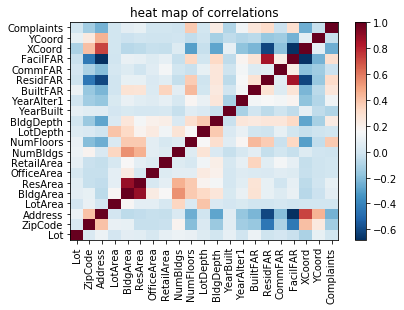

In [63]:
fig, ax = plt.subplots()
im = ax.pcolor(AllForHeat, cmap='RdBu_r')
row_labels = bPlu.columns; col_labels = bPlu.columns
ax.set_xticklabels(row_labels, minor = False);ax.set_yticklabels(col_labels, minor = False)
#move ticks and labels to the center.
ax.set_xticks(np.arange(AllForHeat.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(AllForHeat.shape[0]) + 0.5, minor=False)
ax.set_title("heat map of correlations")
plt.xticks(rotation=90)
plt.colorbar(im)
plt.show()

<p style="color:Red;">Looking along the top row or rightmost column, there appear to be some correlations, though none super strong.  Looking at the actual numbers might help see them better.</p>

In [49]:
#See numerically what the strongest correlations are.
AllForHeat[(AllForHeat['Complaints'].ge(0.05))|(AllForHeat['Complaints'].le(-0.05))]['Complaints'].sort_values(ascending=False)

Complaints    1.000000
NumFloors     0.378491
ResidFAR      0.316187
FacilFAR      0.296346
BuiltFAR      0.260128
BldgDepth     0.228442
YearAlter1    0.122199
ResArea       0.092310
BldgArea      0.074823
YearBuilt    -0.092975
ZipCode      -0.133557
Address      -0.239113
XCoord       -0.248693
Name: Complaints, dtype: float64

In [64]:
# Get the pearson correlations and confidence measures
for col in bPlu.columns:
    pearson_coef, p_value = stats.pearsonr(bPlu[col], bPlu['Complaints'])
    if abs(pearson_coef) > 0.20 and p_value < 0.10:
        print(col, pearson_coef, p_value)

Address -0.23911259732955548 0.0
NumFloors 0.37849069244828526 0.0
BldgDepth 0.22844184143964627 0.0
BuiltFAR 0.2601281246236959 0.0
ResidFAR 0.3161870742364088 0.0
FacilFAR 0.2963456665290026 0.0
XCoord -0.24869254857604323 0.0
Complaints 1.0 0.0


### Visualize strongest correlations

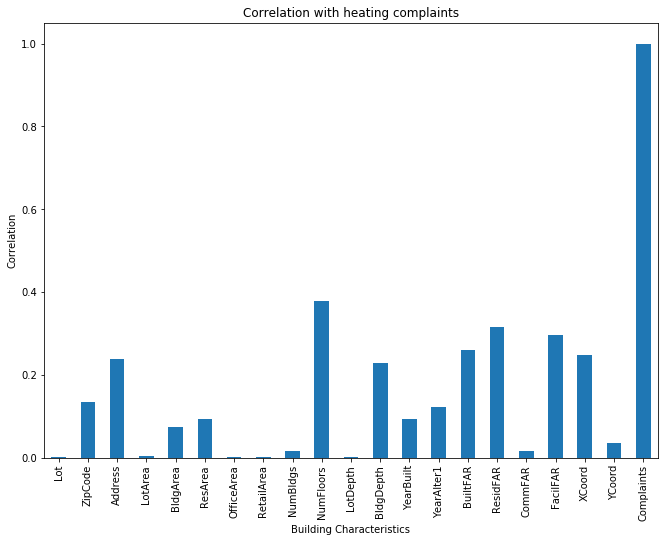

In [62]:
#Visualize
bPlu.corr()['Complaints'].map(abs).plot(kind='bar', title='Correlation with heating complaints',figsize=(11,8))
plt.xlabel('Building Characteristics'); plt.ylabel('Correlation')
plt.show()

<p style="color:Red;">Not really any "strong" correlations, but some weak ones.  Double check the details of a few of these.  Not all characteristics with bars shown above will necessarily be included in final conclusions.</p>

In [52]:
# Address correlates?  Why?
total = bPlu.shape[0]
complainers = bPlu[bPlu['Complaints'].eq(1)].shape[0]
print (total, complainers, complainers / total)

82761 18841 0.22765553823660903


<p style="color:Red;">I think address correlates just because each address either had a complaint or not, so the correlation is about the same as the percentage that had a complaint.  Also, question 2 already narrowed it down geographically so I'm going to dismiss this "correlation" as not relevant to the question at hand.  To a lesser extent the X Coordinate and ZIP code are in the same boat, though there may be a higher (but still very low) correlation than there is with address.</p>

In [53]:
#YearAlter1 correlates?  Why?
total = bPlu.shape[0]
never_altered = bPlu[bPlu['Complaints'].eq(0)].shape[0]
print (total, never_altered, never_altered / total)

82761 63920 0.772344461763391


In [54]:
#Alteration year - take a closer look.
alterations = bPlu[['YearAlter1','Complaints']]
alterations = pd.concat([alterations, pd.get_dummies(alterations['YearAlter1'])], axis=1)
for col in alterations.columns:
    pearson_coef, p_value = stats.pearsonr(alterations[col], alterations['Complaints'])
    if abs(pearson_coef) > 0.05 and p_value < 0.10:
        print(col, pearson_coef, p_value)

YearAlter1 0.12219901524006775 9.544895663940281e-273
Complaints 1.0 0.0
0 -0.12251075532980586 3.862836619193323e-274
1990 0.05039735024130011 1.0874022303045997e-47
1991 0.07266598772420577 2.733969885281605e-97
1992 0.054317050979175045 4.05231805798771e-55


<p style="color:Red;">The only even mildly significant YearAlter1 correlations are between the observations where this field is zero, which is about 2/3 of the data.  My conclusion is that this is a factor of the high number of zeroes, causing the correlation to skew toward lower numbers, hence the lowest numbers, the zeroes themselves, are considered more correlated.</p>

In [55]:
#Year built - take a closer look.
alterations = bPlu[['YearBuilt','Complaints']]
alterations = pd.concat([alterations, pd.get_dummies(alterations['YearBuilt'])], axis=1)
for col in alterations.columns:
    pearson_coef, p_value = stats.pearsonr(alterations[col], alterations['Complaints'])
    if abs(pearson_coef) > 0.05 and p_value < 0.10:
        print(col, pearson_coef, p_value)

YearBuilt -0.09297454315783046 2.8419454113987243e-158
Complaints 1.0 0.0
1907 0.050876745082274424 1.4374139672289905e-48
1909 0.05231791445312461 2.92263481117229e-51
1911 0.057506655894341306 1.4231611677371993e-61
1912 0.062204367623499394 9.478368316389702e-72
1913 0.06513821910741795 1.6424491883625135e-78
1916 0.06163727365595253 1.768629834630244e-70
1922 0.06538155488393875 4.3720256045291284e-79
1923 0.06360472106511389 6.144453402666764e-75
1924 0.06986058882373744 4.743015180155254e-90
1926 0.09329925620334743 2.2678562000047917e-159
1927 0.10979959538718082 2.686933372582767e-220
1928 0.10869495874721928 6.659385634950922e-216
1929 0.0822853534579251 2.7190586263416045e-124
1940 -0.06583613693796092 3.640045123065665e-80
1945 -0.05248796509593236 1.3906336726264787e-51
1950 -0.0884797692002915 1.7938458861523543e-143
1955 -0.06762951979927116 1.6936759647206694e-84
1960 -0.07147415570875999 3.526119715019859e-94


<p style="color:Red;">I was half expecting to see a trend where the complaints got worse or better with the age of the building, but it doesn't really look like that is the case, or if so, then it is more complicated than just the age of the building.  For example, there are no complaints for buildings built in the 1930's but that might just mean there were not many new buildings being constructed during the great depression.</p>

In [56]:
#check a few of these to see if they are different data points that capture the same relationship.
def see_pearson(a,b):
    pearson_coef, p_value = stats.pearsonr(bPlu[a], bPlu[b])
    print(a, b, pearson_coef, p_value)
see_pearson('ResidFAR','FacilFAR')
see_pearson('ResidFAR','BuiltFAR')
see_pearson('FacilFAR','BuiltFAR')

ResidFAR FacilFAR 0.8569114170718753 0.0
ResidFAR BuiltFAR 0.2815406294993035 0.0
FacilFAR BuiltFAR 0.2749098384715888 0.0


<p style="color:Red;">ResidFAR and FacilFAR are strongly correlated.  They are almost the same thing.  The documentation suggests FAR is the "Floor Area Ratio" between the building and the LOT.  The Resid and Facility variations are about the same.  What they have in common is they are both "not commercial".</p>

<a id="conclusion"></a>
# Concluding Remarks
---

The HEATING/HOT WATER complaint types (Question 1) reported in the BRONX borough (question 2) have an obvious (though still somewhat weak) relationship with the following housing characteristics:
<ul>
<li>NumFloors (Number of Floors):  0.37 correlation.
<li>ResidFAR (Maximum Allowable Residential Floor Area Ratio):  0.31 correlation.
</ul>

Additionally there are a few even weaker correlations to the following building characteristics:
<ul>
<li>BldgDepth (Building’s depth, which is the effective perpendicular distance):  0.22 correlation.
<li>BldgArea (Total Building Floor Area):  0.07 correlation.
<li>ResArea (Residential Floor Area):  0.09 correlation.
</ul>

So it appears to basically be the larger the building, and the more residential it is, the more heating complaints.